In [1]:
pip install -r requirements.txt


[notice] A new release of pip available: 22.2.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import imageio.v3 as iio
from PIL import Image
import numpy as np

In [3]:
import models as m
import utils as u

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


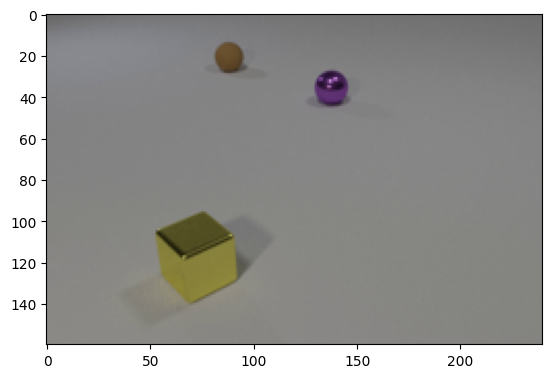

In [5]:
# look at the first image in the first video of the unlabeled data
plt.imshow(iio.imread('Dataset_Student/unlabeled/video_2000/image_0.png'))

In [6]:
# load in data from first 11 frames for each video

path = 'Dataset_Student/unlabeled/video_'
to_tensor = transforms.ToTensor()

data_x = []
for video in range(2000, 3000): # eventually use 15000
    # get the image path for each frame of each video
    img_path = path + str(video)
    video = []
    for frame in range(0, 11):
        fin_path = os.path.join(img_path, 'image_' + str(frame)+ '.png')
        # open image and convert to tensor
        img = Image.open(fin_path)
        img = to_tensor(img)
        video.append(img)
    video = torch.stack(video, dim=0)
    data_x.append(video)
data_x = torch.stack(data_x, dim=0)
data_x = data_x.reshape(data_x.size(0), data_x.size(1)*data_x.size(2), data_x.size(3), data_x.size(4))
print('Final Size of data_x tensor:', data_x.size()) # (number of videos, number of frames*color channels, image width, image height)

Final Size of data_x tensor: torch.Size([1000, 33, 160, 240])


In [7]:
# load in data from 22nd (last) frame for each video
data_y = []
for video in range(2000, 3000): # eventually use 15000
    # get the image path for the 22nd frame of each video
    img_path = path + str(video)
    fin_path = os.path.join(img_path, 'image_21.png')
    # open image and convert to tensor
    img = Image.open(fin_path)
    img = to_tensor(img).unsqueeze(0)
    data_y.append(img)
data_y = torch.stack(data_y, dim=0)
data_y = data_y.reshape(data_y.size(0), data_y.size(1)*data_y.size(2), data_y.size(3), data_y.size(4))
print('Final Size of data_y tensor:', data_y.size()) # (number of videos, number of frames*color channels, image width, image height)

Final Size of data_y tensor: torch.Size([1000, 3, 160, 240])


In [8]:
# batch size for training
batch_size = 8

# feed into dataloader
data = u.MyDataset(data_x, data_y)
dataloader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False)

In [9]:
# set parameters for patch embeddings
image_size = (160, 240)
patch_size = 4
embed_dim = 64
expander_out = 4096

model = m.VICReg(image_size, patch_size, embed_dim, expander_out=expander_out)

In [10]:
# forward pass model to test
import time

num_epochs = 2
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

t0 = time.time()
for epoch in range(num_epochs):
    model.train()
    epoch_loss = []
    i = 0
    print('training:')
    for data in tqdm(dataloader, desc=f'epoch {epoch}'):
        x, y = data
        optimizer.zero_grad()
        loss = model(x, y)
        
        epoch_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        i += 1
        if i > 5: break
    print(f'Epoch {epoch} loss: {np.mean(epoch_loss)}')
    

print(f'Finished training in {(time.time()-t0)/60} minutes')

training:


epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]/Users/andrechen/Documents/documentslocal/NYU_MSDS/video_prediction_project/utils.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(self.inputs[idx], dtype=torch.float32)
/Users/andrechen/Documents/documentslocal/NYU_MSDS/video_prediction_project/utils.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_data = torch.tensor(self.labels[idx], dtype=torch.float32)
epoch 0:   4%|▍         | 5/125 [12:04<4:49:55, 144.96s/it]


AttributeError: 'list' object has no attribute 'mean'